In [1]:
using Random
using Distributions
using Plots

In [2]:
function tauchen(N,mu,rho,sigma,m)
    """
    ---------------------------------------------------
    === AR(1)過程をtauchenの手法によって離散化する関数 ===
    ---------------------------------------------------
    ※z'=(1-ρ)μ + ρ*z + ε, ε~N(0,σ_{ε}^2) を離散化する

    <input>
    ・N: 離散化するグリッドの数
    ・mu: AR(1)過程の定数項(上式のμ)
    ・rho: AR(1)過程の慣性(上式のρ)
    ・sigma: AR(1)過程のショック項の標準偏差(上式のσ_{ε})
    ・m: 離散化するグリッドの範囲に関するパラメータ
    <output>
    ・Z: 離散化されたグリッド
    ・Zprob: 各グリッドの遷移行列
    """
    Zprob = zeros(N,N) # 遷移確率の行列
    c = (1-rho)*mu # 定数項

    # 等間隔のグリッドを定める
    # 最大値と最小値
    zmax = m*sqrt(sigma^2/(1-rho^2))
    zmin = -zmax
    # グリッド間の間隔
    w = (zmax-zmin)/(N-1)

    Z  = collect(range(zmin,zmax,length=N))
    # 定常状態はmu(E[Z]=mu)
    Z .+= mu

    # グリッド所与として遷移確率を求める
    for j in 1:N # 今期のZのインデックス
        for k in 1:N  # 来期のZのインデックス
            if k == 1
                Zprob[j,k] = cdf_normal((Z[k]-c-rho*Z[j]+w/2)/sigma)
            elseif k == N
                Zprob[j,k] = 1 - cdf_normal((Z[k]-c-rho*Z[j]-w/2)/sigma)
            else
                Zprob[j,k] = cdf_normal((Z[k]-c-rho*Z[j]+w/2)/sigma) - cdf_normal((Z[k]-c-rho*Z[j]-w/2)/sigma)
            end
        end
    end

    return Z,Zprob 

end

tauchen (generic function with 1 method)

In [3]:
function cdf_normal(x)
    """
    --------------------------------
    === 標準正規分布の累積分布関数 ===
    --------------------------------
    <input>
    ・x: 
    <output>
    ・c: 標準正規分布にしたがう確率変数Xがx以下である確率
    """
    d = Normal(0,1) # 標準正規分布
    c = cdf(d,x)

    return c
    
end

cdf_normal (generic function with 1 method)

In [4]:
function Rouwenhorst(rho,sigmas,znum)
    """
    --------------------------------------------------------------------------------
    === Creates a discrete approximation to a first order autoregressive process ===
    --------------------------------------------------------------------------------
    # with serial correlation p + q - 1.  See Rouwenhorst (1995) (pps. 325-329)
    # in Cooley <i>Frontiers of Business Cycle Research</i> Princeton.
    """

    p = (rho+1)/2;
    q = p;

    hlag = 1;
    h = [];

    for i in 2:znum
        
        vec0 = zeros(i-1);
        h = p*[hlag vec0; vec0' 0] + (1-p)*[vec0 hlag; 0 vec0'] + (1- q)*[vec0' 0; hlag vec0] + q*[0 vec0'; vec0 hlag];
	    h[2:i-1,:] = h[2:i-1,:]./2; 
        hlag = h;
    end

    PI = h;

    # symmetrically and evenly spaced between [-epsilon, epsilon] with h elements.  
    # When p = q, then then variance of shock is epsilon^2/(h-1).  

    zvar = (sigmas^2)/( 1 - rho^2);
    epsilon = sqrt((znum - 1)*zvar);

    Z = collect(range(-epsilon, epsilon, length=znum));

    return Z,PI
end

Rouwenhorst (generic function with 1 method)

In [5]:
# マルコフチェーンによるシミュレーション

N = 5;
mu = 0;
rho = 0.95;
sigma = 0.01
m = 2.575 # 分布の95％をカバーする

Z, Pz = tauchen(N,mu,rho,sigma,m)
#Z,Pz = Rouwenhorst(rho,sigma,N);

# シミュレーションを行う
# 外生的なショックの配列を作る
T = 1000
ivec = zeros(Int64,T+1)
ivec[1] = 3
# 条件付き累積密度関数(遷移行列の各行について累積和を求める)
cumP = cumsum(Pz,dims=2) 

# T期分のシミュレーションを行う
for t in 1:T
    cumPi = cumP[ivec[t],:] 
    rand1 = rand(Uniform(0,1)) # 一様分布から[0,1]の値を取る乱数を発生させる
    # 乱数を条件付き累積密度分布と比較する
    # 例えば、rand<cumPi[1]のとき、ivec[t+1]=1となる
    # 同様に、cumPi[1]<rand<cumPi[2]のとき、ivec[t+1]=2となる
    ivec[t+1] = sum(rand1 .- cumPi .>= 0) + 1
    ivec[t+1] = min(ivec[t+1],N)
end

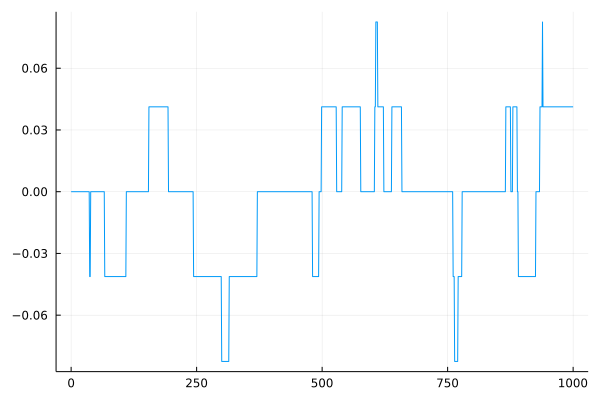

In [6]:
plot(0:T,Z[ivec],legend=false)